<a href="https://colab.research.google.com/github/Capsar/.fiddy/blob/master/Copy_of_Ensemble_LSTM_Encoder_Decoder_Plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Prediction with LSTM Using PyTorch

This kernel is based on *datasets* from

[Time Series Forecasting with the Long Short-Term Memory Network in Python](https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/)

[Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)

[Seq2Seq model with Encoder & Decoder in PyTorch](
https://www.guru99.com/seq2seq-model.html)

In [ ]:
#pip install pytorch-forecasting

## Library

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import random


## Toy Data generator

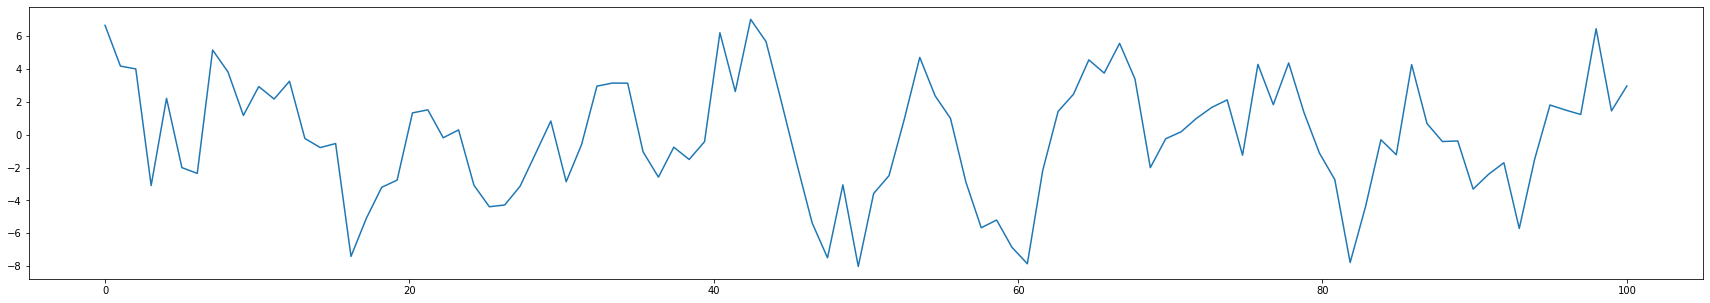

In [ ]:
'''
input = [(amplitude, cycle_steps, offset)]
if cycle_steps = 20, it takes 20 steps to perform 1 sin-wave.
'''
def generateData(length=100, input=[(3, 10, 1)], std=1):
  size = np.linspace(0, length, length)
  output = np.empty([len(input), length])
  for i, (a, b, c) in enumerate(input):
    x = np.linspace(c, length+c, length) 
    output[i] = a*np.sin((2*np.pi/b)*x) + np.random.normal(0, std, length)
  return size, output.sum(axis=0)

x, toy_data_example = generateData(length=100, input=[(1, 13, 1), (2, 31, 1), (4, 11, 4), (1, 7, 1)])

plt.figure(figsize=(30,5))
plt.plot(x, toy_data_example)
plt.show()

## Setup Training and Testing Dataframes

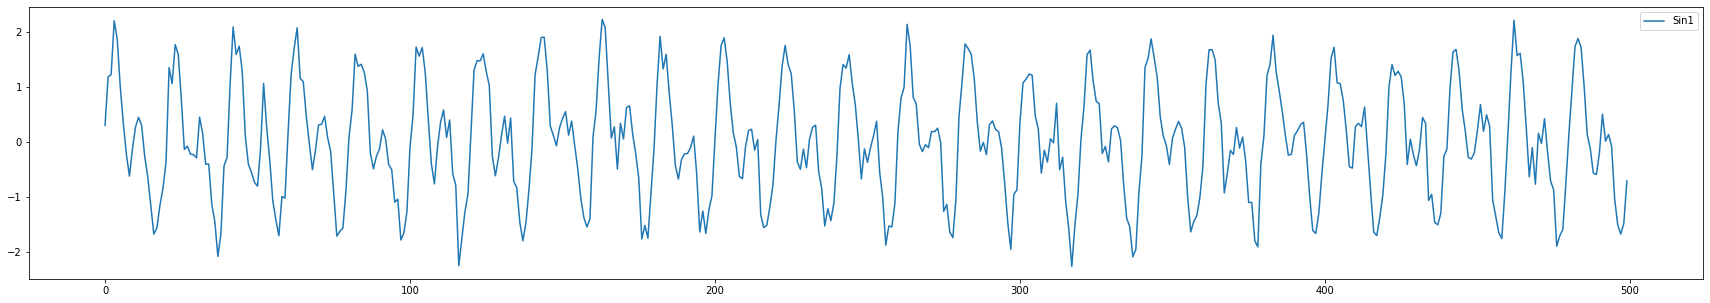

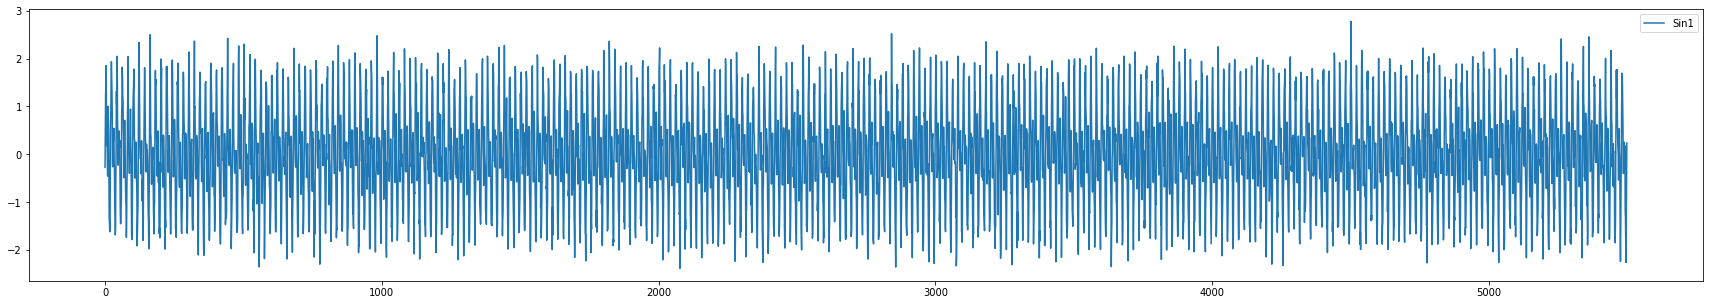

In [ ]:
from pandas.core.frame import DataFrame
import datetime

def setupDailyMinTemperatures(features=["Date", "Temp"], targets=["Temp"]):
  dataset_url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv"
  df = pd.read_csv(dataset_url)
  df['Date'] = pd.to_datetime(df['Date'])
  start_date = datetime.datetime(year=1988, month=6, day=1)

  test_mask = df['Date'] >= start_date
  train_mask = ~test_mask

  training_df = df.loc[train_mask].copy()
  test_df = df.loc[test_mask].copy()

  print("Test set fraction:", len(test_df) / len(df))

# Turn date data into float data.
  training_df["Date"] = training_df['Date'].dt.dayofyear.divide(365)
  test_df["Date"] = test_df["Date"].dt.dayofyear.divide(365)
  return features, targets, training_df, test_df

def setupToyData1():
  features = ["Sin1"]
  targets = ["Sin1"]
  _, sin = generateData(length=6000, input=[(1, 20, 0)], std=0)
  train_size = 1000
  training_df = pd.DataFrame(sin[:train_size], columns=features)
  test_df = pd.DataFrame(sin[train_size:], columns=features)
  return features, targets, training_df, test_df

def setupToyData2():
  features = ["Sin1"]
  targets = ["Sin1"]
  _, sin = generateData(length=6000, input=[(1, 20, 0),(1, 10, 0)], std=0.2)
  train_size = 500
  training_df = pd.DataFrame(sin[:train_size], columns=features)
  test_df = pd.DataFrame(sin[train_size:], columns=features)
  return features, targets, training_df, test_df

# features, targets, training_df, test_df = setupDailyMinTemperatures()
features, targets, training_df, test_df = setupToyData2()
training_df.plot(figsize=(30,5))
plt.show()
test_df.plot(figsize=(30,5))
plt.show()



## Dataloading 2

Plot batch example: torch.Size([100, 40, 1]) torch.Size([100, 500, 1]) torch.Size([100])


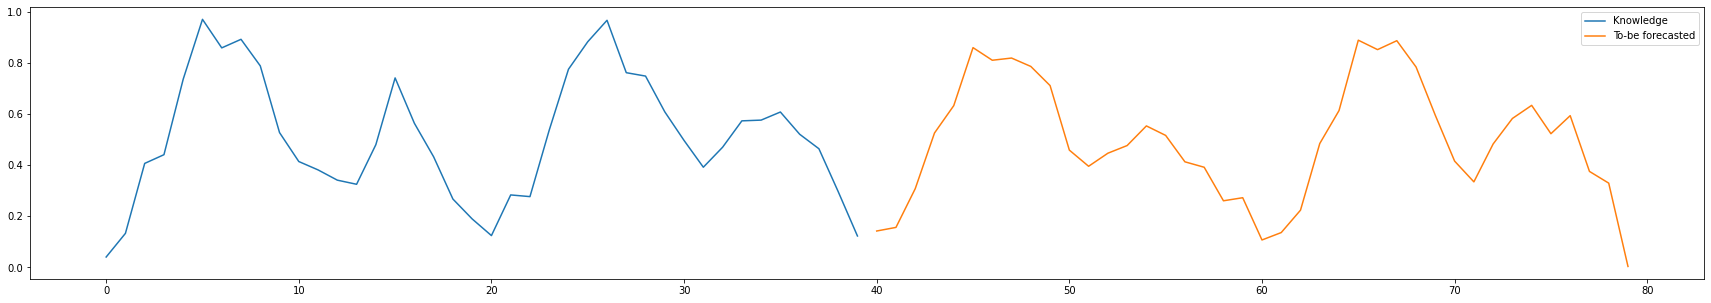

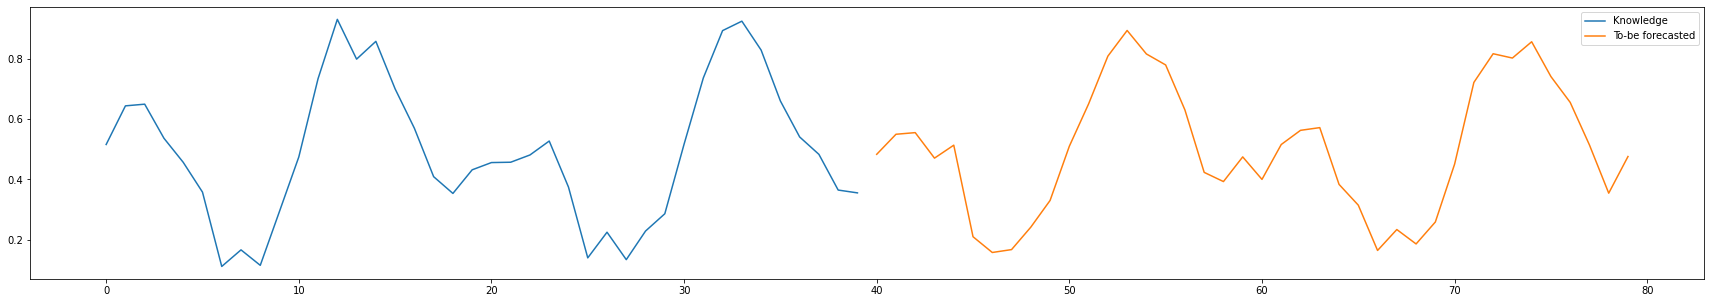

In [ ]:

# Source: https://www.crosstab.io/articles/time-series-pytorch-lstm
class SequenceDataset(Dataset):
  def __init__(self, dataframe, target, features, input_sequence_length=5, output_sequence_length=5):
    self.scaler = MinMaxScaler()
    self.features = features
    self.target = target
    self.input_sequence_length = input_sequence_length
    self.output_sequence_length = output_sequence_length
    self.Y = torch.tensor(self.scaler.fit_transform(dataframe[target].values)).float()
    self.X = torch.tensor(self.scaler.fit_transform(dataframe[features].values)).float()

  def __len__(self):
    return self.X.shape[0]

  def __getitem__(self, t): 
    if t >= self.input_sequence_length:
      t_start = t - self.input_sequence_length
      x = self.X[t_start:t, :]
    else:
      padding = self.X[0].repeat(self.input_sequence_length - t, 1)
      x = self.X[0:t, :]
      x = torch.cat((padding, x), 0)

    if t <= self.Y.shape[0] - self.output_sequence_length:
      t_end = t + self.output_sequence_length
      y = self.Y[t:t_end, :]
    else:
      padding = self.Y[-1].repeat(self.output_sequence_length - (self.Y.shape[0] - t), 1)
      y = self.Y[t:self.Y.shape[0], :]
      y = torch.cat((y, padding), 0)
    return x, y, self.Y, t

def plot_data_loader_batch(loaderX, loadery, loaderY, t, batches=2):
  print('Plot batch example:', loaderX.shape, loaderY.shape, t.shape)
  batch_size = loaderX.shape[0]
  for batch_index in range(0, min(batches, batch_size)):
    loaderX_size = loaderX.detach().numpy()[batch_index,:,:].shape[0]
    loaderY_size = loaderY.shape[1]+loaderX_size
    t_size = t[batch_index]

    range1 = range(0, loaderX_size)
    range2 = range(loaderX_size-1, loaderY_size-t_size)
    range3 = range(loaderX_size, loaderX_size+loadery.shape[1])

    plt.figure(figsize=(30,5))
    plt.plot(range1, loaderX.detach().numpy()[batch_index,:,:], label="Knowledge")
    # plt.plot(range2, loaderY.detach().numpy()[batch_index, t_size-1:,:])
    plt.plot(range3, loadery[batch_index,], label="To-be forecasted")
    plt.legend()
    plt.show()

input_sequence_length = 40
output_sequence_length = 40
train_dataset = SequenceDataset(training_df, target=targets, features=features, input_sequence_length=input_sequence_length, output_sequence_length=output_sequence_length)

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)

#Training batch example
trainX, trainy, trainY, train_t = next(iter(train_loader))
plot_data_loader_batch(trainX, trainy, trainY, train_t)




## Encoder

In [ ]:
class Encoder(nn.Module):
  def __init__(self, input_size, hidden_dim, num_layers):
    super(Encoder, self).__init__()
    
    #set the encoder input dimesion, hidden dimesion, and number of layers 
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers

    #intialize the LSTM to take the input dimention, and output dimention of hidden and set the number of LSTM layers
    self.lstm = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first=True)
       
  def forward(self, input):
    outputs, (hidden, cell) = self.lstm(input)
    return hidden, cell

## Decoder

In [ ]:
class Decoder(nn.Module):
  def __init__(self, output_size, hidden_size, num_layers):
    super(Decoder, self).__init__()
    self.output_size = output_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers

    self.lstm = nn.LSTM(input_size=self.output_size, hidden_size=self.hidden_size, num_layers=self.num_layers)
    self.fc_out = nn.Linear(hidden_size, output_size)
  
  def forward(self, input, hidden, cell):
    input = input.unsqueeze(0)
    output, (hidden, cell) = self.lstm(input, (hidden, cell))
    prediction = self.fc_out(output.squeeze(0))
    return prediction, output, hidden, cell

## Seq2Seq Model

In [ ]:
class Seq2Seq(nn.Module):
  def __init__(self, encoder, decoder):
    super(Seq2Seq, self).__init__()

    self.encoder = encoder
    self.decoder = decoder

    assert encoder.hidden_size == decoder.hidden_size, "Hidden dimensions of encoder and decoder must be equal!"
    assert encoder.num_layers == decoder.num_layers, "Encoder and decoder must have equal number of layers!"

  def forward(self, input, true_output, max_target_length=1):
    batch_size = true_output.shape[0]
    target_length = max(max_target_length, true_output.shape[1])
    output_features = true_output.shape[2]

    #input.shape = [batch_size, seq_length, output_features]
    hidden, cell = self.encoder(input)
  	
    # Creating a Tensor for the outputs with shape [seq_length, batch_size, output_features]
    outputs = torch.zeros(target_length, batch_size, output_features)
    # As all required info for the decoder should be in the hidden state of the encoder, the first input to the decoder should not matter.
    input = torch.zeros(batch_size, output_features)

    for t in range(0, target_length):
      output, _, hidden, cell = self.decoder(input, hidden, cell)
      outputs[t] = output
      input = output
    return outputs

## Weighted loss

In [ ]:
class weighted_MSEloss(nn.Module):
    '''
    y: prediction outputs
    y_label: ground_truth
    '''
    def __init__(self, decay_factor):
      super(weighted_MSEloss, self).__init__()
      self.decay_factor = decay_factor
        
    def forward(self, y, y_label):
      # y shape = [batch_size, seq_length, num_targets]
      loss = (y - y_label).square()
      decay_vector = torch.ones(y.shape[1])*self.decay_factor
      exp = torch.arange(y.shape[1])
      decay_vector = torch.pow(decay_vector, exp).reshape(-1, 1)
      loss = loss*decay_vector
      # loss = loss * ((1 - self.decay_factor) / (1 -  torch.pow(decay_vector, y.shape[1])))
      loss = loss.sum() / y.shape[0]
      return loss

criterion_test = weighted_MSEloss(1.02)
y_test = torch.tensor([
                       [[0.75],
                        [0.75]],
                       [[0.75],
                        [0.75]],
                       [[0.75],
                        [0.75]],
                       [[0.75],
                        [0.75]],
                       [[0.75],
                        [0.75]]
                       ])
y_test_label = torch.ones(size=[5, 2, 1])
criterion_test(y_test, y_test_label)

tensor(0.1262)

## Initialize Ensemble

In [ ]:
learning_rate = 0.01

hidden_size = 5
num_layers = 1

lstms = []
num_of_lstms = 5
optimizers = []

#Required to init the models with random weights, making the models in the ensemble different.
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.normal_(param.data)

for i in range(num_of_lstms):
  encoder = Encoder(len(features), hidden_size, num_layers)
  decoder = Decoder(len(targets), hidden_size, num_layers,)
  model = Seq2Seq(encoder, decoder)
  model.apply(init_weights)

  lstms.append(model)
  optimizers.append(torch.optim.Adam(model.parameters(), lr=learning_rate))

# criterion = torch.nn.MSELoss()
criterion = weighted_MSEloss(0.95)

## Train Ensemble LSTMs

In [ ]:
def train(model, optimizer, criterion, data_loader):
  model.train()
  total_loss = 0

  for X, y, _, _ in data_loader:
    output = model(X, y)
    output = torch.swapaxes(output, 0, 1)
    loss = criterion(output, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
  return total_loss / len(data_loader)

num_epochs = 500
for i in range(num_of_lstms): 
  print("Train model ", i)

  # Train the model
  for epoch in range(num_epochs):
    # print('trainX:', trainX.shape, 'trainY', trainY.shape)
    loss = train(lstms[i], optimizers[i], criterion, train_loader)
    if epoch % round(num_epochs/10) == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss))


Train model  0
Epoch: 0, loss: 4.41953
Epoch: 50, loss: 0.60446
Epoch: 100, loss: 0.48376
Epoch: 150, loss: 0.44542
Epoch: 200, loss: 0.40669
Epoch: 250, loss: 0.37430
Epoch: 300, loss: 0.35836
Epoch: 350, loss: 0.38353
Epoch: 400, loss: 0.34427
Epoch: 450, loss: 0.27416
Train model  1
Epoch: 0, loss: 1.66598
Epoch: 50, loss: 0.80071
Epoch: 100, loss: 0.70520
Epoch: 150, loss: 0.59978
Epoch: 200, loss: 0.46410
Epoch: 250, loss: 0.38202
Epoch: 300, loss: 0.32878
Epoch: 350, loss: 0.30551
Epoch: 400, loss: 0.28570
Epoch: 450, loss: 0.23078
Train model  2
Epoch: 0, loss: 16.88202
Epoch: 50, loss: 0.81211
Epoch: 100, loss: 0.79489
Epoch: 150, loss: 0.63279
Epoch: 200, loss: 0.51074
Epoch: 250, loss: 0.25261
Epoch: 300, loss: 0.22253
Epoch: 350, loss: 0.20015
Epoch: 400, loss: 0.18708
Epoch: 450, loss: 0.18629
Train model  3
Epoch: 0, loss: 2.72781
Epoch: 50, loss: 0.58314
Epoch: 100, loss: 0.49696
Epoch: 150, loss: 0.47783
Epoch: 200, loss: 0.37862
Epoch: 250, loss: 0.20456
Epoch: 300, los

## Plot forecast of LSTMs 

Test model  0
Model loss: tensor(0.1085)


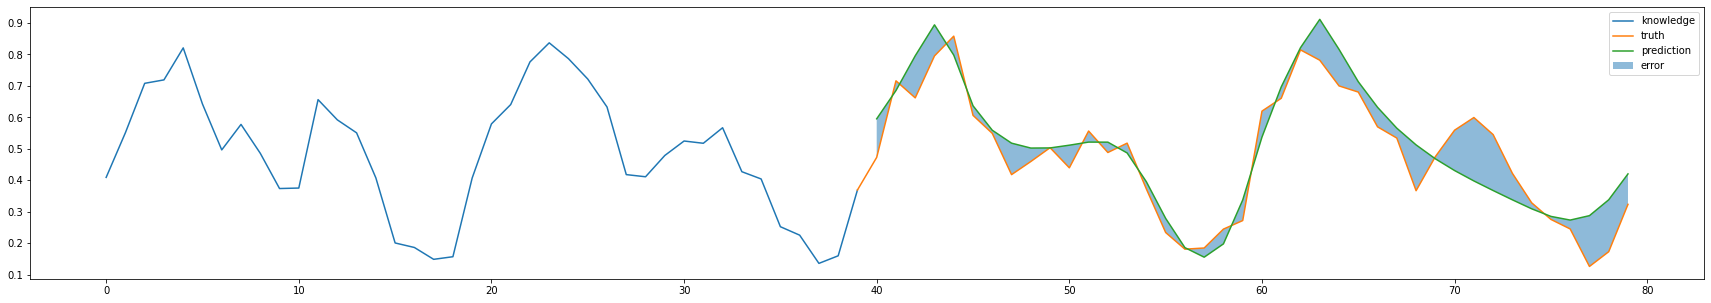

Test model  1
Model loss: tensor(0.1323)


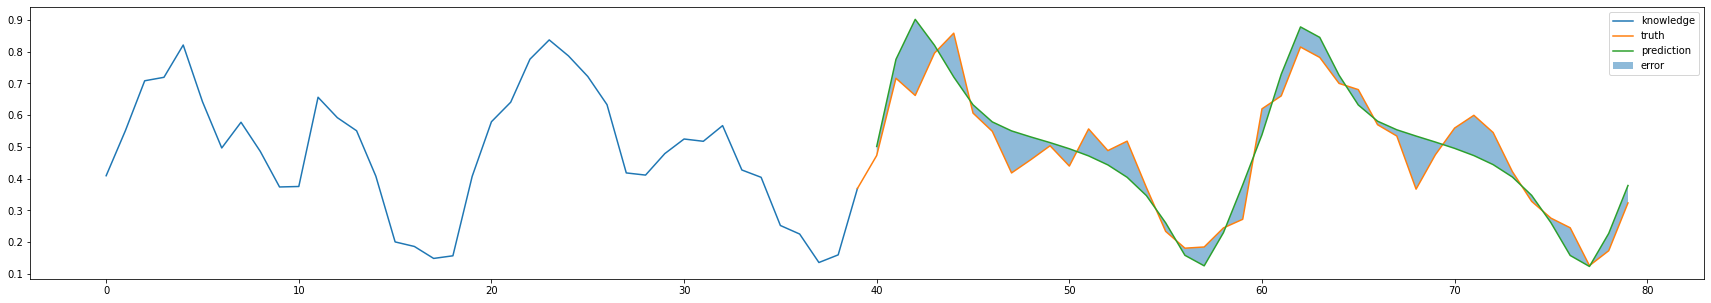

Test model  2
Model loss: tensor(0.1056)


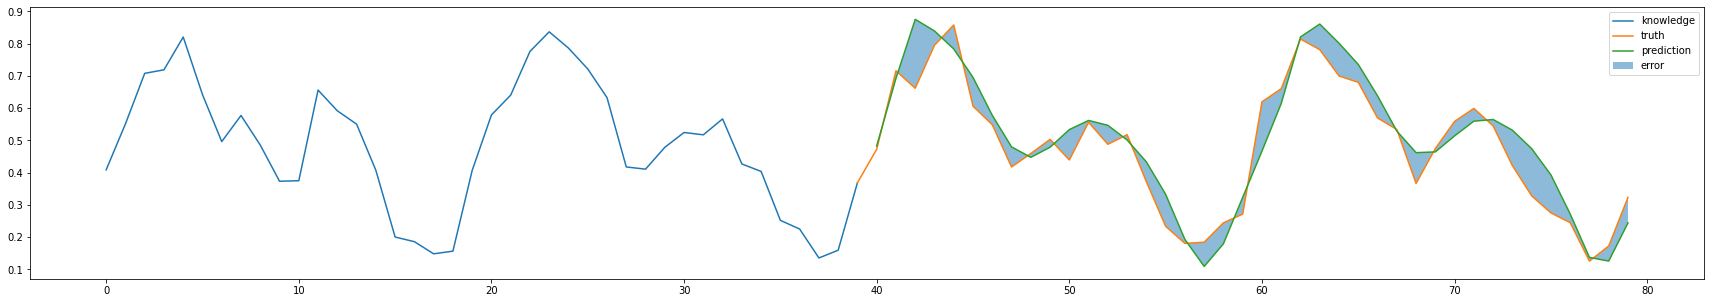

Test model  3
Model loss: tensor(0.0900)


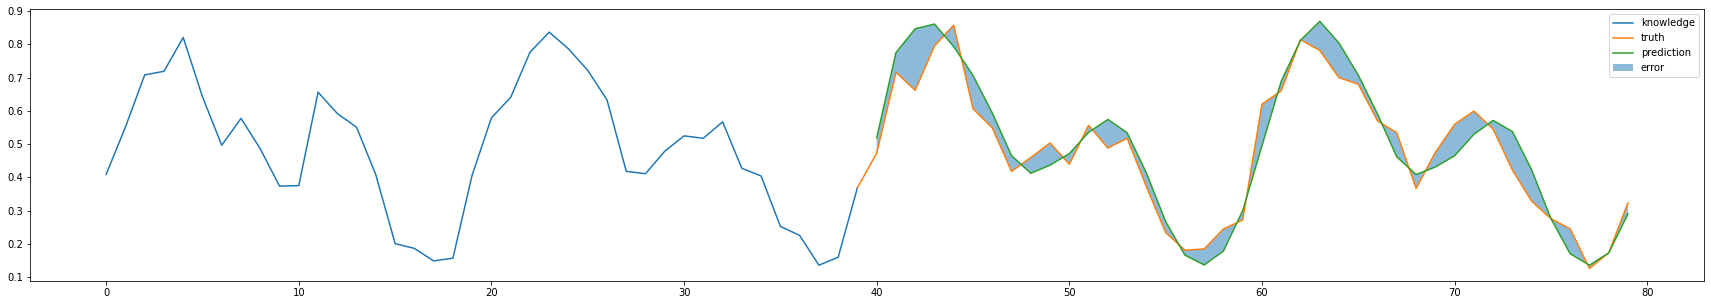

Test model  4
Model loss: tensor(0.1570)


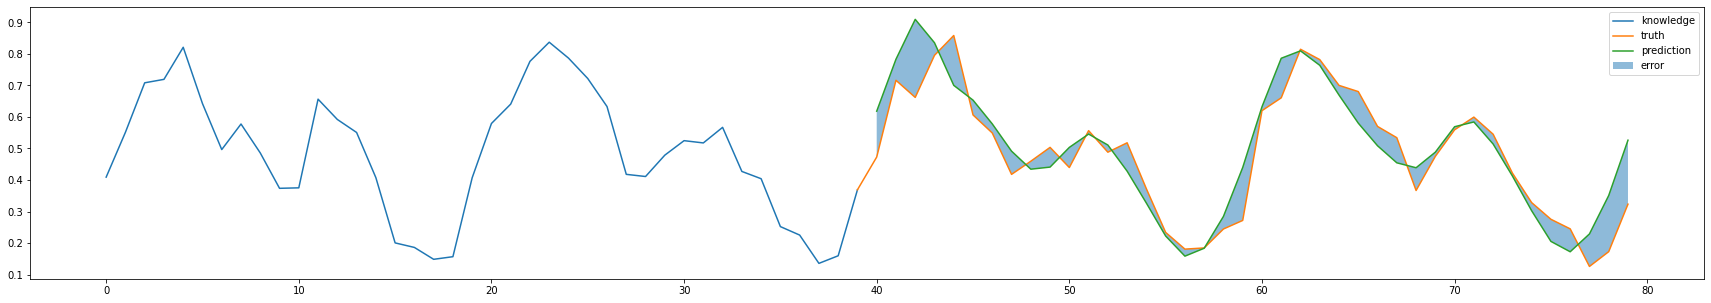

In [ ]:
test_dataset = SequenceDataset(test_df, target=targets, features=features, input_sequence_length=input_sequence_length, output_sequence_length=output_sequence_length)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
# testX, testy, testY, test_t = next(iter(test_loader))
# plot_data_loader_batch(testX, testy, testY, test_t)

test_loader = iter(test_loader)
for xx in range(0, input_sequence_length):
  next(test_loader)

X, y, Y, t = next(test_loader)
# print(X.shape, y.shape, Y.shape, t)

with torch.no_grad():
  for i in range(num_of_lstms): 
    print("Test model ", i)

    lstms[i].eval()
    output = lstms[i](X, y)
    output = torch.swapaxes(output, 0, 1)
    loss = criterion(output[:,0:y.shape[1]], y)
    print("Model loss:", loss)

    output_numpy = output.detach().numpy()
    y_numpy = Y.detach().numpy()


    batch_index = 0
    tt = t[batch_index]
    plt.figure(figsize=(30,5))
    plt.plot(range(0,X.shape[1]), X[batch_index,], label='knowledge')
    plt.plot(range(X.shape[1]-1, X.shape[1]+output_numpy[batch_index,].shape[0]), Y[batch_index,tt-1:tt+output_numpy[batch_index,].shape[0],:], label='truth')
    # plt.plot(range(X.shape[1], X.shape[1]+y[batch_index,].shape[0]), y[batch_index,], label='truth')
    plt.plot(range(X.shape[1], X.shape[1]+output_numpy[batch_index,].shape[0]), output_numpy[batch_index,], label='prediction')

    truth = Y[batch_index,tt:tt+output_numpy[batch_index,].shape[0],:]
    prediction = output_numpy[batch_index,]
    plt.fill_between(x=range(X.shape[1], X.shape[1]+output_numpy[batch_index,].shape[0]), y1=truth.reshape(-1), y2=prediction.reshape(-1), label='error', alpha=.5, linewidth=0)

    plt.legend()
    plt.show()


Streaming output truncated to the last 5000 lines.
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
7

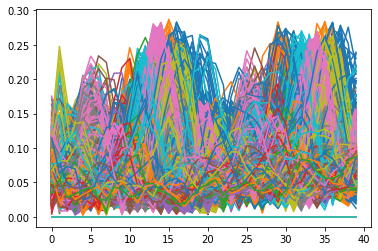

ValueError: ignored

In [ ]:
deviations = np.array([])
errors = np.array([])
timestep = 0

predicted_outputs = np.empty((len(test_loader), num_of_lstms, output_sequence_length, len(targets)))
real_outputs = np.empty((len(test_loader), num_of_lstms, output_sequence_length, len(targets)))

for batch_id, (X, y, _, _) in enumerate(test_loader):
  print(batch_id)
  for i in range(num_of_lstms): 
    lstms[i].eval()
    output = lstms[i](X, y)
    output = torch.swapaxes(output, 0, 1)
    predicted_outputs[batch_id, i] = output.detach().numpy()
    real_outputs[batch_id, i] = output.detach().numpy()
  # break

# print(predicted_outputs[0])
# plt.plot(predicted_outputs[0].reshape(-1, 1))
# plt.show()
predicted_std_outputs = np.std(predicted_outputs, axis=1)
print(predicted_std_outputs[0])
for predicted_std in predicted_std_outputs:
  plt.plot(predicted_std)
plt.show()


# for i in data_predicts:
#   deviations = np.append(deviations, np.std(i))
#   errors = np.append(errors, np.square(np.subtract(dataY_plot[timestep],np.mean(i))) )
#   timestep+=1

errors = np.reshape(errors, errors.size)

sc_extra = MinMaxScaler()
N = 200 ## This value can be adjusted
moving_averages_deviations = np.convolve(deviations, np.ones(N)/N, mode='valid')
moving_averages_deviations = sc_extra.fit_transform(moving_averages_deviations.reshape(-1, 1)) 
moving_averages_errors = np.convolve(errors, np.ones(N)/N, mode='valid')
moving_averages_errors = sc_extra.fit_transform(moving_averages_errors.reshape(-1, 1)) 


plt.plot(moving_averages_deviations, label='variations')
plt.plot(moving_averages_errors, label='errors')
plt.suptitle('Time-Series Prediction errors and variance of the ensemble')
plt.legend()
plt.show()
# deviations = sc_extra.fit_transform(deviations.reshape(-1, 1)) 
# errors = sc_extra.fit_transform(errors.reshape(-1, 1)) 
number_cut_offs= 500
m_avgr_var_cut_off=moving_averages_deviations[number_cut_offs:]
m_avgr_error_cut_off=moving_averages_errors[number_cut_offs:]
# plt.plot(deviations, color='lightgray')

plt.plot(m_avgr_var_cut_off, label='variations')
plt.plot(m_avgr_error_cut_off, label='errors')
plt.suptitle('Time-Series Prediction errors and variance of the ensemble - With cut off')
plt.legend()
plt.show()

In [ ]:
from scipy.stats import gaussian_kde

plt.scatter(m_avgr_var_cut_off, m_avgr_error_cut_off, s=2)
plt.xlabel("Variance")
plt.ylabel("MSE")
plt.suptitle('Time-Series Prediction moving average scatterplot of the ensemble')
plt.show()


scatter_deviations = np.clip(deviations, 0, 1.0)
scatter_errors = np.clip(errors, 1, 30)

# Calculate the point density
xy = np.vstack([deviations,errors])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
# idx = z.argsort()
# deviations, errors, z = deviations[idx], errors[idx], z[idx]

plt.scatter(scatter_deviations, scatter_errors, c=z, s=2)
plt.xlabel("Variance")
plt.ylabel("MSE")
plt.suptitle('Time-Series Prediction realvalue scatterplot of the ensemble')
plt.show()